In [8]:
import pathlib
import sys
from torchvision import transforms as T
from torch.utils.data import DataLoader
import json

src = pathlib.Path().absolute().parent

sys.path.append(str(src))

from src.models.segmentation.unet import UNet
from src.data.segmentation import BoxSegmentationDataset, LGGSegmentationDataset 
from src.enums import DataSplit
from src.data.datasets import LGG_NORMALIZE_TRANSFORM
from src.utils.transforms import DualInputCompose, DualInputResize, DualInputTransform, ImgOnlyTransform
from src.utils.visualize import plot_semantic_predictions

LOG_DIR = src / 'logs'
MODEL_REGISTRY = src / 'model_registry'
DATASETS = src / 'datasets'

base_transforms = DualInputCompose([DualInputResize((320, 320)), DualInputTransform(T.ToTensor())])


In [9]:
def load_and_test(type: str, path: pathlib.Path, normalized: bool = False, transforms: DualInputCompose = base_transforms):
    model = UNet.load(path)
    if type == "box":
        dataset = BoxSegmentationDataset(root_dir=DATASETS, split=DataSplit.TEST, transform=transforms)
    elif type == "lgg":
        if normalized:
            transforms = DualInputCompose([*transforms.transforms, ImgOnlyTransform(LGG_NORMALIZE_TRANSFORM)])
            
        dataset = LGGSegmentationDataset(root_dir=DATASETS, split=DataSplit.TEST, transform=transforms)
    else:
        raise ValueError("Invalid type")
    
    loader = DataLoader(dataset, batch_size=6, shuffle=False)
    model.eval()
    imgs, masks = next(iter(loader))
    preds = model(imgs)
    preds = preds.sigmoid().round().int()
    plot_semantic_predictions(imgs, masks, preds, include_overlay=True)

In [10]:
best_lgg_score = 0
best_lgg_norm_score = 0
best_box_score = 0

best_lgg = None
best_lgg_norm = None
best_box = None

for exp_dir in MODEL_REGISTRY.iterdir():
    for run_dir in exp_dir.iterdir():
        exp_path = str(run_dir).split('model_registry/')[-1]
        metric_path = LOG_DIR / exp_path / 'metrics.json'
        if not metric_path.exists():
            continue
        with open(metric_path, 'r') as f:
            metrics = json.load(f)
        
        check_points = list(run_dir.glob("*.pth"))
        steps = [int(check_point.stem.split("_")[-1]) for check_point in check_points]
        for i, step in enumerate(steps):
            step = str(step)
            if 'lgg' in exp_path and metrics.get(str(step)) is not None:
                if 'normalized' in exp_path:
                    if metrics[step]['val_BinaryIoU'] > best_lgg_norm_score:
                        best_lgg_norm_score = metrics[step]['val_BinaryIoU']
                        best_lgg_norm = check_points[i]
                elif metrics[step]['val_BinaryIoU']> best_lgg_score:
                    best_lgg_score = metrics[step]['val_BinaryIoU']
                    best_lgg = check_points[i]
            elif 'box' in exp_path and metrics.get(str(step)) is not None:
                if metrics[step]['val_BinaryIoU']> best_box_score:
                    best_box_score = metrics[step]['val_BinaryIoU']
                    print(metrics[step]['val_BinaryAUROC'])
                    best_box = check_points[i]
    
print(f"Best LGG Model: {best_lgg}, Val IoU: {best_lgg_score}")
print(f"Best Box Model: {best_box}, Val IoU: {best_box_score}")
print(f"Best LGG Normalized Model: {best_lgg_norm}, Val IoU: {best_lgg_norm_score}")

0.976610004901886
0.9743586778640747
0.9746702909469604
Best LGG Model: /home/jhrudd/dev/brain-cancer-classifier-segmentation/model_registry/Train_Segmentation_unet_lgg_2024-04-09_16:42:22/unet_lgg_2024-04-09_16-42-22/model_checkpoint_50.pth, Val IoU: 0.7027262449264526
Best Box Model: /home/jhrudd/dev/brain-cancer-classifier-segmentation/model_registry/Train_Segmentation_unet_box_2024-04-07_17:08:15/unet_box_2024-04-07_17-08-15/model_checkpoint_50.pth, Val IoU: 0.5762611031532288
Best LGG Normalized Model: /home/jhrudd/dev/brain-cancer-classifier-segmentation/model_registry/Train_Segmentation_unet_lgg_normalized_2024-04-14_13:48:35/unet_lgg_2024-04-14_13-48-35/model_checkpoint_25.pth, Val IoU: 0.7087579965591431


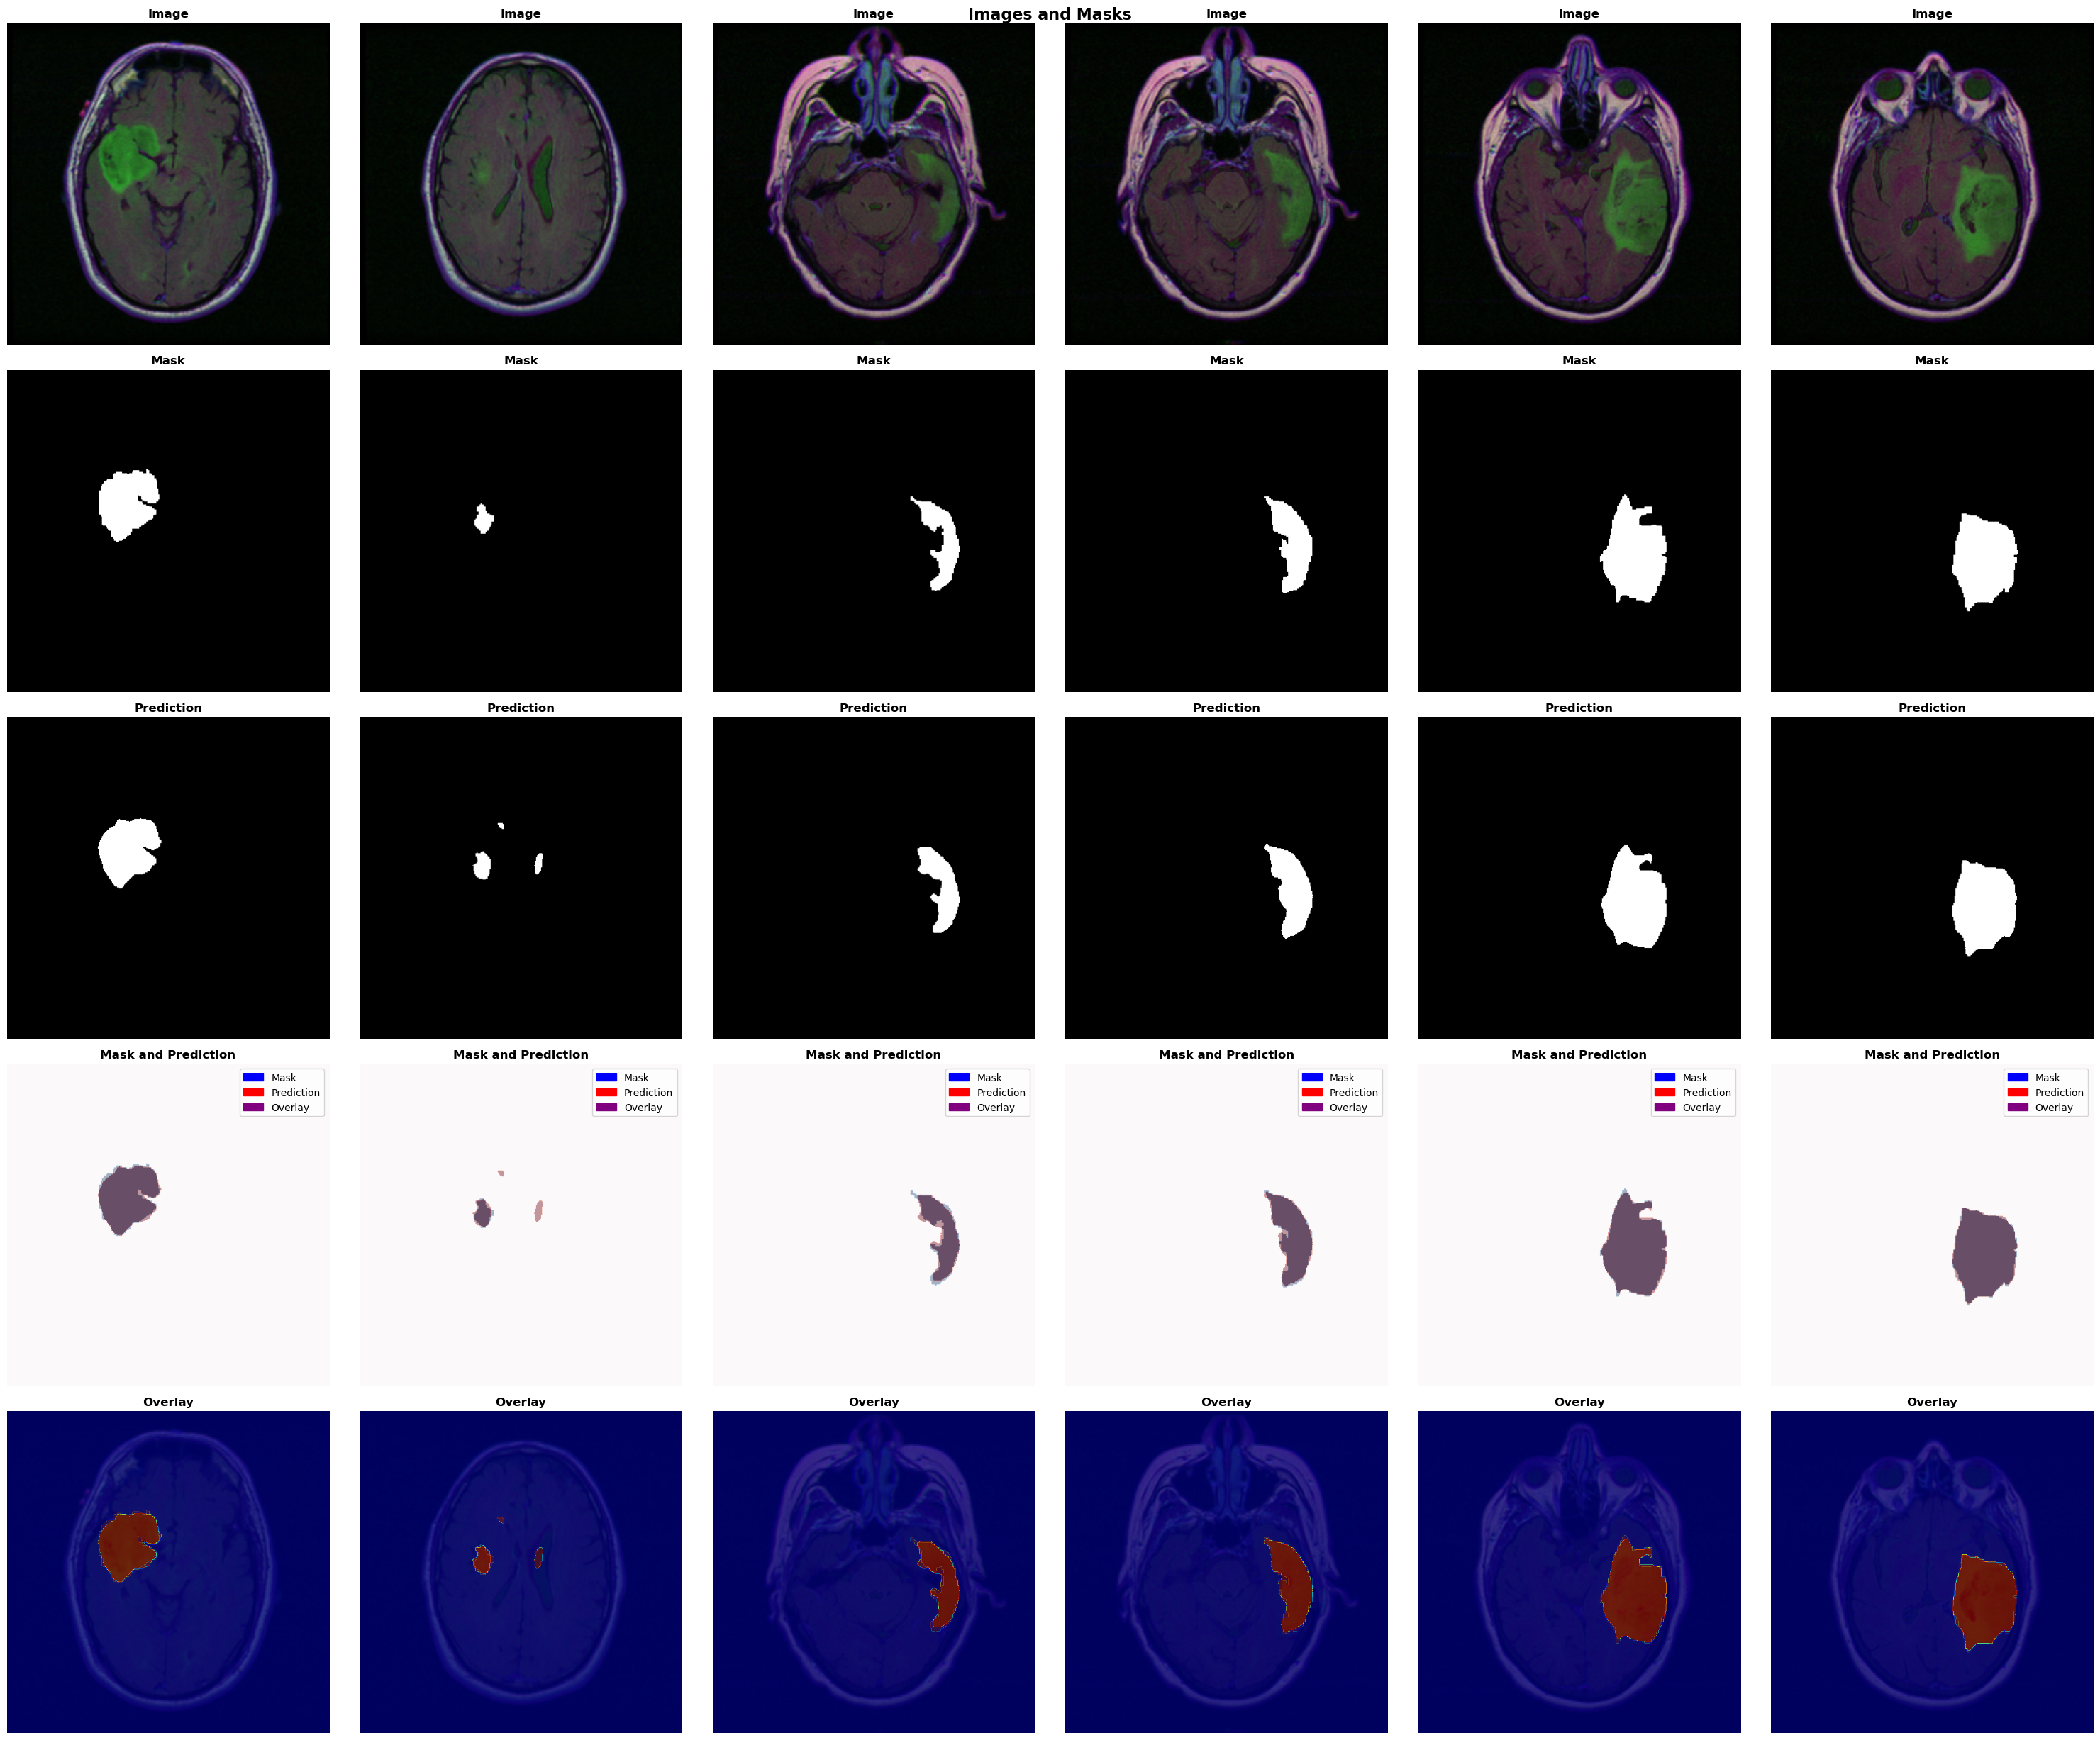

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

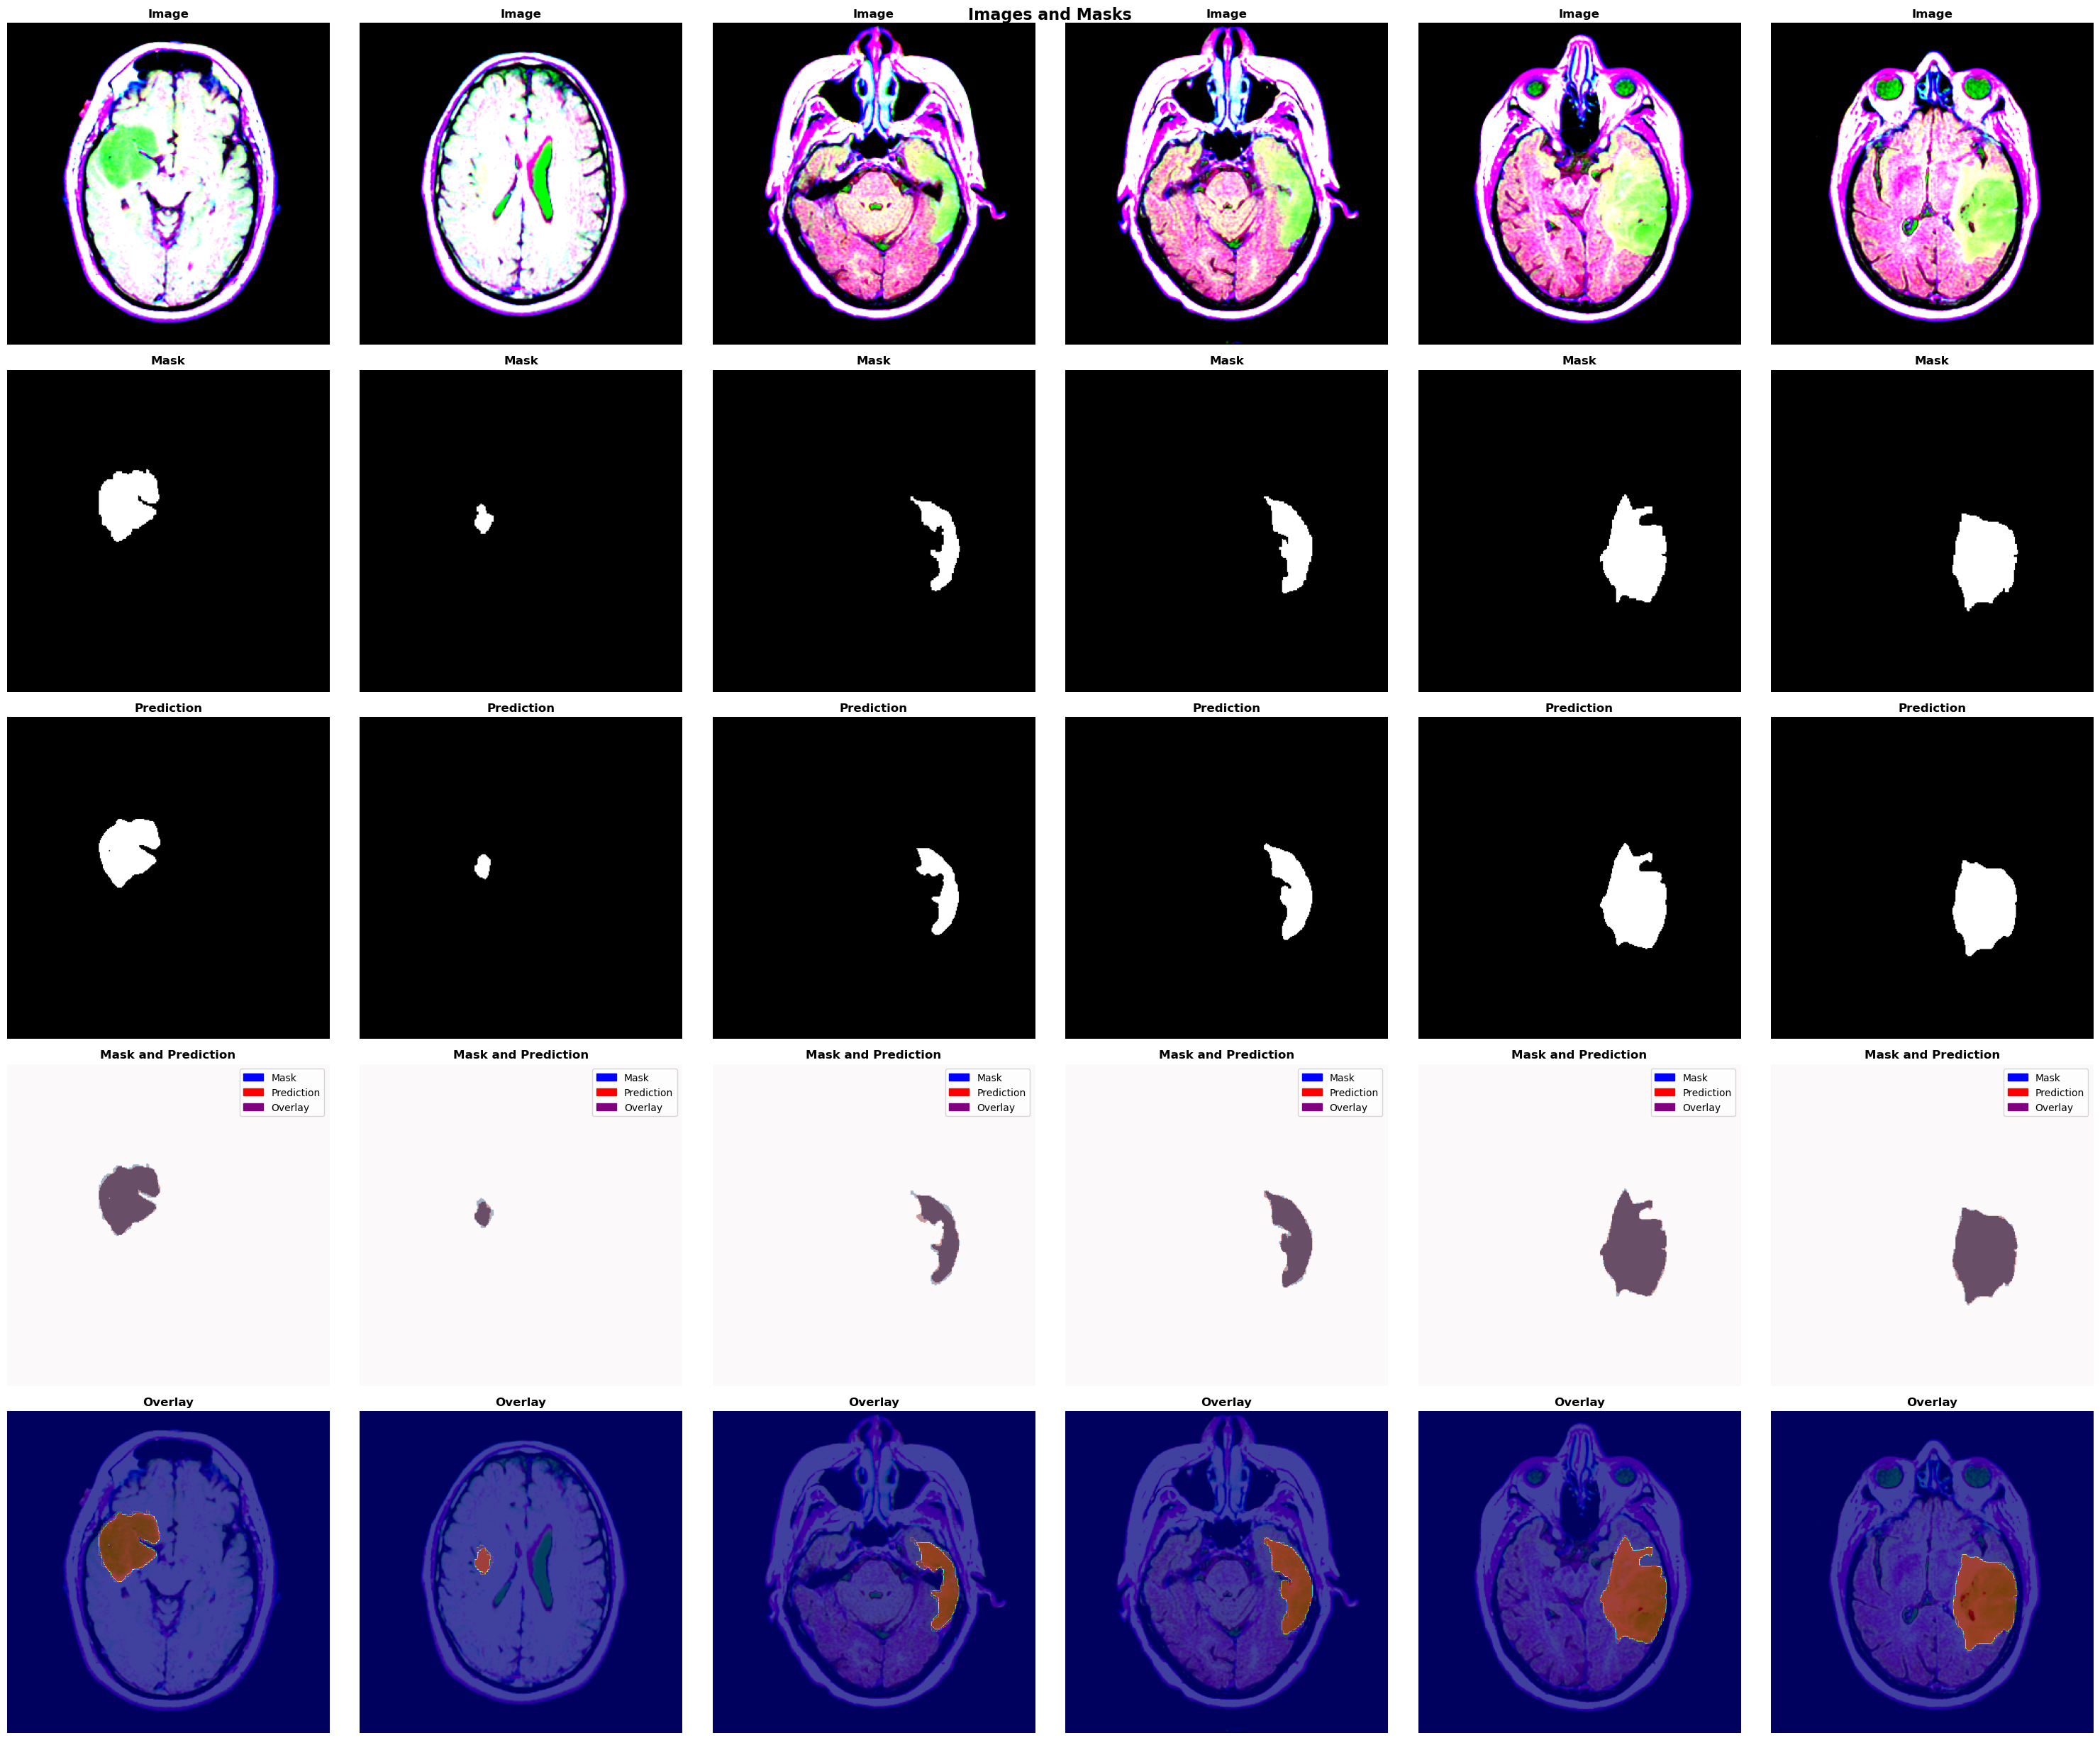

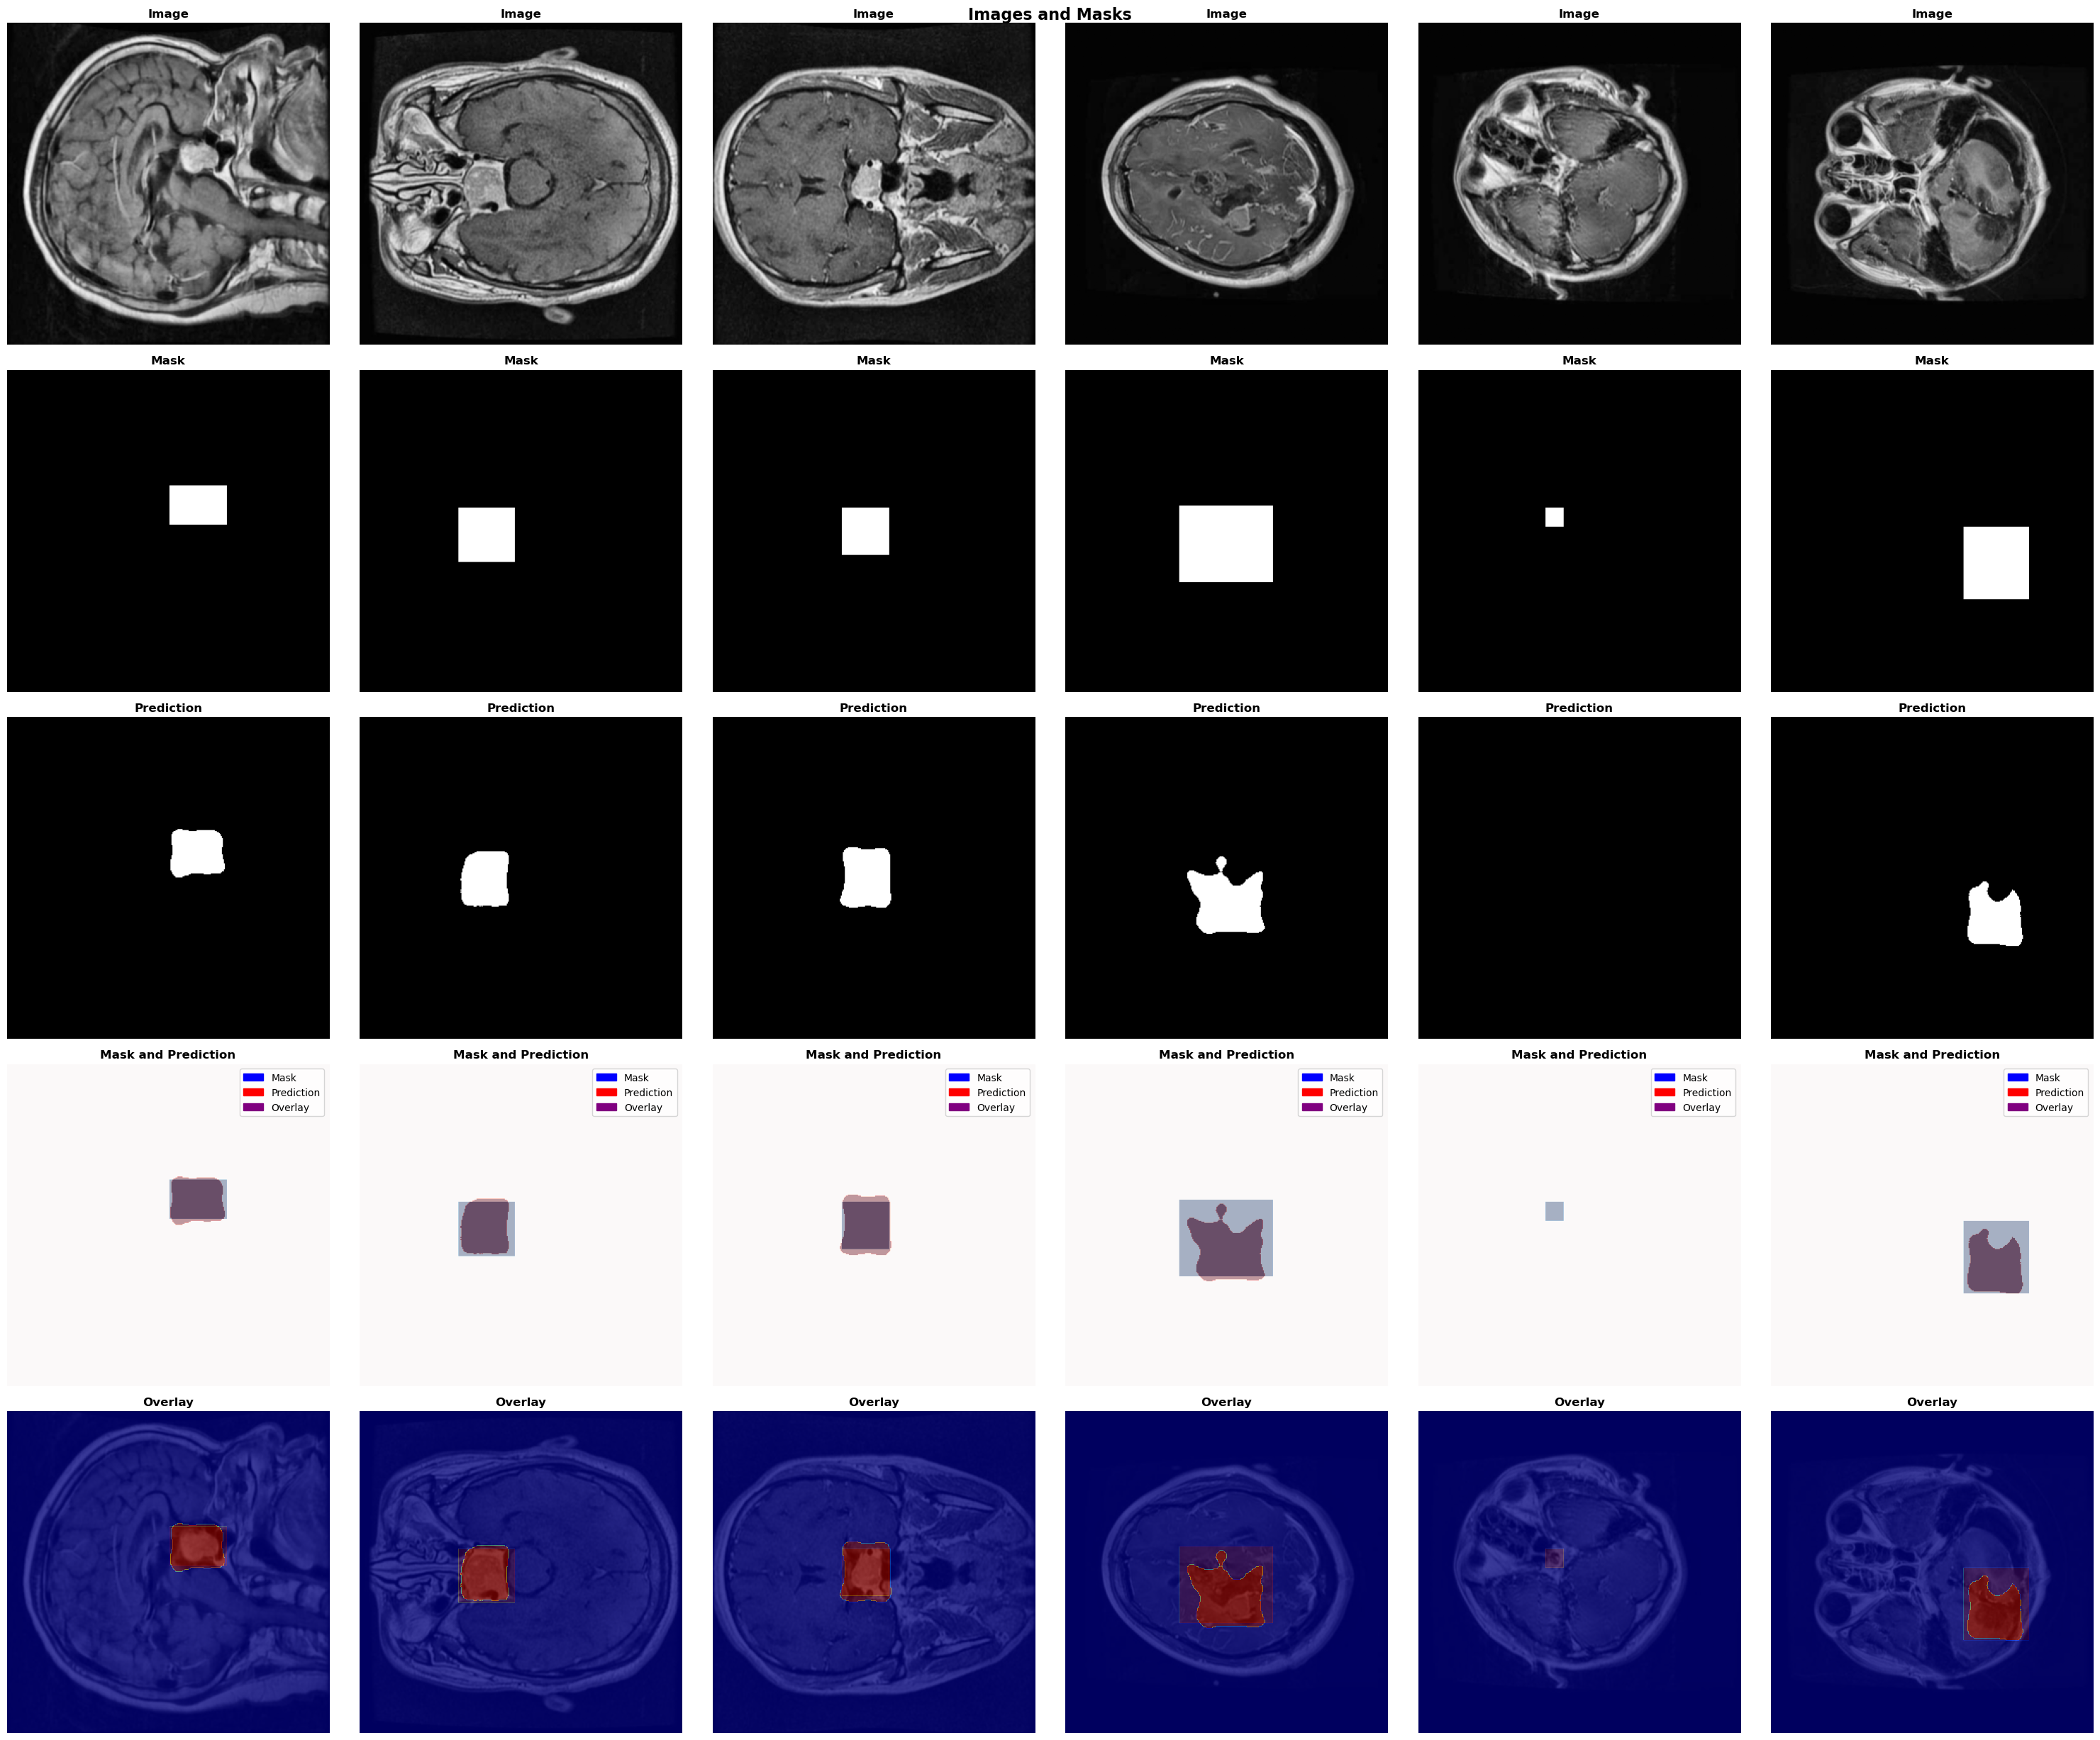

In [11]:
load_and_test("lgg", best_lgg)
load_and_test("lgg", best_lgg_norm, normalized=True)
load_and_test("box", best_box)